In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# //////////////// DATA CLEANING ////////////////

df_raw = pd.read_csv("48_Industry_Portfolios.csv", header=None, delimiter=",", engine="python")
df = df_raw.iloc[12:1193] # retrieve weighted monthly returns 
df = df.iloc[:, 1:].apply(pd.to_numeric, errors="coerce") #convert datatypes to numeric

# Define column names for data frame
col_names = df_raw.iloc[11].tolist()[1:]
df.columns = col_names #set col names

# Select 5/48 industries
selected_industries = ["Food ", "Smoke", "Drugs", "MedEq", "Telcm"]
selected_df = df[selected_industries]
selected_df


,Food,Smoke,Drugs,MedEq,Telcm
12,0.12,1.29,0.91,4.95,0.83
13,2.68,6.50,4.26,4.20,2.17
14,1.58,1.26,-0.26,4.02,2.41
15,-3.68,1.06,-1.76,3.47,-0.11
16,6.26,4.55,5.76,4.33,1.63
...,...,...,...,...,...
1188,4.06,11.69,1.23,-2.55,3.84
1189,5.09,7.96,6.28,7.56,1.21
1190,0.95,-1.31,-3.10,0.83,5.63
1191,-4.28,8.46,-3.27,-1.11,2.36


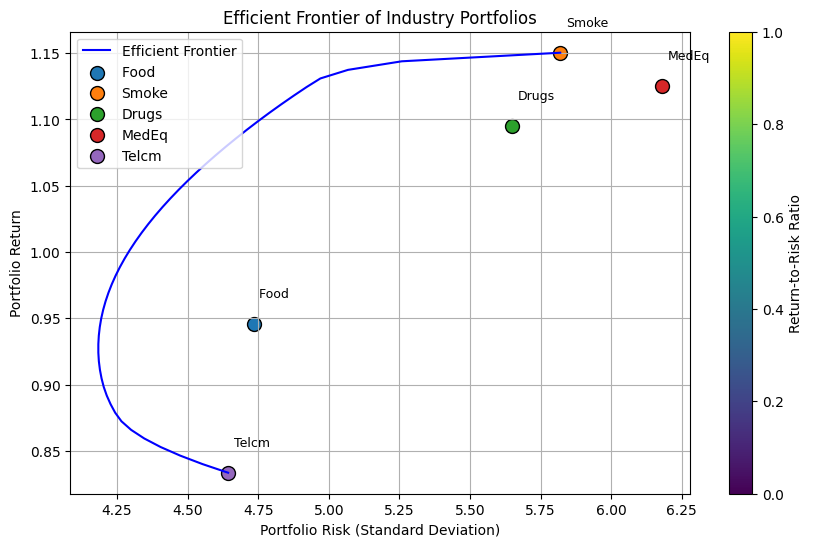

In [23]:
# //////////////// 1) EFFICIENT FRONTIER W/O RISK-FREE ASSET ////////////////
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming selected_df is already loaded and contains the industry returns

# Step 1: Calculate mean returns and covariance matrix of the returns
mean_returns = selected_df.mean()
cov_matrix = selected_df.cov()

# Number of assets (industry portfolios)
n_assets = len(mean_returns)

# Step 2: Define the objective function to minimize the portfolio variance
def objective(weights, cov_matrix):
    return 0.5 * np.dot(weights.T, np.dot(cov_matrix, weights))

# Step 3: Define the constraint functions
# 1. Weights must sum to 1
def constraint1(weights):
    return np.sum(weights) - 1

# 2. Portfolio return must equal target return u
def constraint2(weights, mean_returns, target_return):
    return np.dot(weights, mean_returns) - target_return

# Step 4: Generate a range of target returns for the efficient frontier
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)

# Step 5: Solve for each target return
results = np.zeros((2, len(target_returns)))  # To store risk and return

for i, target_return in enumerate(target_returns):
    # Initial guess for portfolio weights (equal weights)
    initial_weights = np.ones(n_assets) / n_assets
    
    # Define the constraints for this target return
    constraints = [
        {'type': 'eq', 'fun': constraint1},  # Weights sum to 1
        {'type': 'eq', 'fun': constraint2, 'args': (mean_returns, target_return)}  # Portfolio return equals target
    ]
    
    # Define the bounds for the weights (e.g., no short-selling)
    bounds = [(0, 1) for _ in range(n_assets)]
    
    # Solve the optimization problem
    result = minimize(objective, initial_weights, args=(cov_matrix), constraints=constraints, bounds=bounds)
    
    # Store the results
    weights = result.x
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    results[0, i] = portfolio_risk  # Store the portfolio risk
    results[1, i] = portfolio_return  # Store the portfolio return

# Step 6: Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(results[0], results[1], label="Efficient Frontier", color='b')

# Step 7: Plot individual industry portfolios
for i in range(n_assets):
    # Portfolio risk (volatility) and return for individual industries
    industry_return = mean_returns.iloc[i]  # Use .iloc to access by position
    industry_vol = np.sqrt(cov_matrix.iloc[i, i])  # Standard deviation of the individual industry
    
    # Scatter plot for the individual industry portfolio
    plt.scatter(industry_vol, industry_return, label=selected_df.columns[i], s=100, edgecolors='black', marker='o')

    # Annotate each industry portfolio with its name
    plt.text(industry_vol + 0.02, industry_return + 0.02, selected_df.columns[i], fontsize=9)

# Step 8: Customize plot with titles and labels
plt.title('Efficient Frontier of Industry Portfolios')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')

# Add a color bar for the efficient frontier
plt.colorbar(label='Return-to-Risk Ratio')

# Show the plot
plt.grid(True)
plt.legend(loc='upper left')
plt.show()



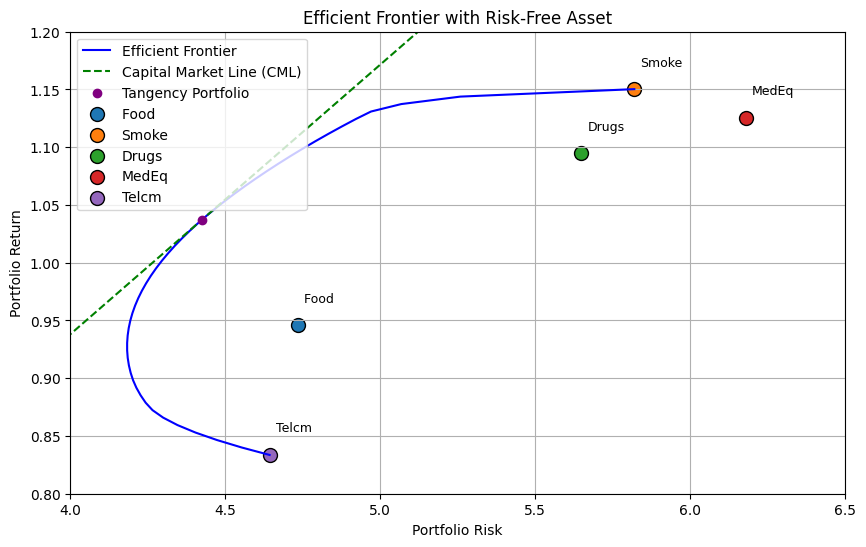

  Industry  Optimal Weights
0    Food          0.115377
1    Smoke         0.330315
2    Drugs         0.152716
3    MedEq         0.158144
4    Telcm         0.243448
Return:  1.0372055039251582
Volatility:  4.425083637412162


In [59]:
# //////////////// 2) EFFICIENT FRONTIER W/ RISK-FREE ASSET ////////////////

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import matplotlib.ticker as ticker

# Assuming selected_df is already loaded and contains the industry returns

# Step 1: Calculate mean returns and covariance matrix of the returns
mean_returns = selected_df.mean()
cov_matrix = selected_df.cov()

# Number of assets (industry portfolios)
n_assets = len(mean_returns)

# Risk-free rate
Rf = 0.004

# Step 2: Define the objective function to minimize the portfolio variance
def objective(weights, cov_matrix):
    return 0.5 * np.dot(weights.T, np.dot(cov_matrix, weights))

# Step 3: Define the constraint functions
# 1. Weights must sum to 1
def constraint1(weights):
    return np.sum(weights) - 1

# 2. Portfolio return must equal target return u
def constraint2(weights, mean_returns, target_return):
    return np.dot(weights, mean_returns) - target_return

# Step 4: Generate a range of target returns for the efficient frontier
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)

# Step 5: Solve for each target return
results = np.zeros((2, len(target_returns)))  # To store risk and return

for i, target_return in enumerate(target_returns):
    # Initial guess for portfolio weights (equal weights)
    initial_weights = np.ones(n_assets) / n_assets
    
    # Define the constraints for this target return
    constraints = [
        {'type': 'eq', 'fun': constraint1},  # Weights sum to 1
        {'type': 'eq', 'fun': constraint2, 'args': (mean_returns, target_return)}  # Portfolio return equals target
    ]
    
    # Define the bounds for the weights (e.g., no short-selling)
    bounds = [(0, 1) for _ in range(n_assets)]
    
    # Solve the optimization problem
    result = minimize(objective, initial_weights, args=(cov_matrix), constraints=constraints, bounds=bounds)
    
    # Store the results
    weights = result.x
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    results[0, i] = portfolio_risk  # Store the portfolio risk
    results[1, i] = portfolio_return  # Store the portfolio return

# Step 6: Find the Tangency Portfolio (maximize the Sharpe ratio)
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_vol  # Negative for maximization

# Initial guess for the tangency portfolio
initial_weights = np.ones(n_assets) / n_assets

# Constraints: sum of weights equals 1
constraints = {'type': 'eq', 'fun': constraint1}

# Solve the optimization problem for the tangency portfolio
result = minimize(sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, Rf), constraints=constraints, bounds=[(0, 1)] * n_assets)

# Get the tangency portfolio weights
tangency_weights = result.x
tangency_return = np.dot(tangency_weights, mean_returns)
tangency_vol = np.sqrt(np.dot(tangency_weights.T, np.dot(cov_matrix, tangency_weights)))

# Step 7: Calculate the Capital Market Line (CML)
# CML equation: Return = Rf + (E[Rm] - Rf) / sigma_m * sigma
cml_x = np.linspace(0, tangency_vol * 1.2, 100)
cml_y = Rf + (tangency_return - Rf) / tangency_vol * cml_x

# Step 8: Plot the Efficient Frontier with Tangency Portfolio and CML
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Efficient Frontier (Risky Assets)
ax.plot(results[0], results[1], label="Efficient Frontier", color='b')

# Plot the Capital Market Line (CML)
ax.plot(cml_x, cml_y, label="Capital Market Line (CML)", color='g', linestyle='--')

# Plot the Tangency Portfolio
ax.scatter(tangency_vol, tangency_return, color='purple', label='Tangency Portfolio', zorder=5)

# Step 9: Plot individual industry portfolios
for i in range(n_assets):
    # Portfolio risk (volatility) and return for individual industries
    industry_return = mean_returns.iloc[i]  # Use .iloc to access by position
    industry_vol = np.sqrt(cov_matrix.iloc[i, i])  # Standard deviation of the individual industry
    
    # Scatter plot for the individual industry portfolio
    ax.scatter(industry_vol, industry_return, label=selected_df.columns[i], s=100, edgecolors='black', marker='o')

    # Annotate each industry portfolio with its name
    ax.text(industry_vol + 0.02, industry_return + 0.02, selected_df.columns[i], fontsize=9)

# Customize the plot with titles and labels
ax.set_title('Efficient Frontier with Risk-Free Asset')
ax.set_xlabel('Portfolio Risk')
ax.set_ylabel('Portfolio Return')
ax.set_ylim(0.8, 1.2)
ax.set_xlim(4.0,6.5)

# Show the plot
ax.grid(True)
ax.legend(loc='upper left')
plt.show()




# Create a dictionary to store the results
results_dict = {
    'Industry': selected_df.columns,  
    'Optimal Weights': tangency_weights,
}

# Create a DataFrame from the dictionary
tangency_df = pd.DataFrame(results_dict)

print(tangency_df) 
print('Return: ', tangency_return)
print('Volatility: ', tangency_vol)




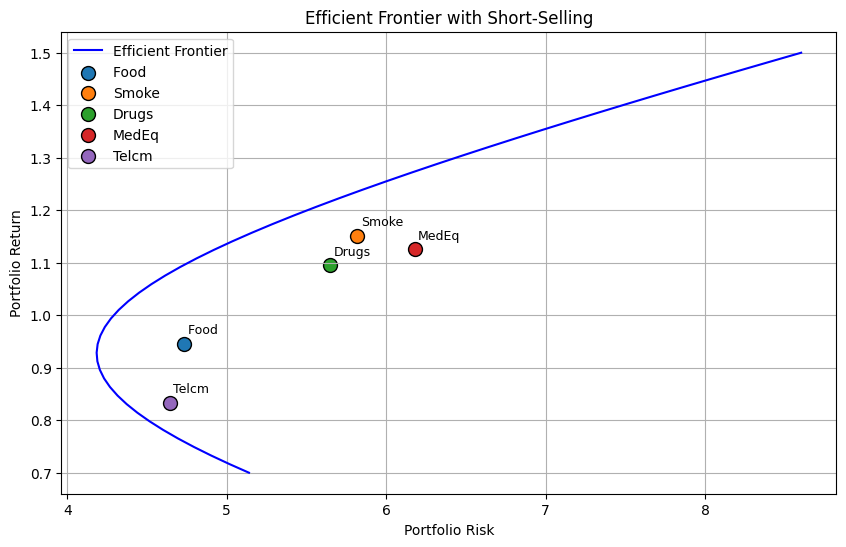

In [58]:
# //////////////// 3) EFFICIENT FRONTIER (W/O RISK-FREE ASSET), SHORT-SELL ALLOWED ////////////////

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Assuming selected_df is the DataFrame of industry returns

# Step 1: Calculate mean returns and covariance matrix of the returns
mean_returns = selected_df.mean()
cov_matrix = selected_df.cov()

# Number of assets (industries)
n_assets = len(mean_returns)

# Step 2: Define the objective function to minimize the portfolio variance
def objective(weights, cov_matrix):
    return 0.5 * np.dot(weights.T, np.dot(cov_matrix, weights))

# Step 3: Define the constraint that the weights sum to 1
def constraint1(weights):
    return np.sum(weights) - 1

# Step 4: Generate a range of target returns for the efficient frontier
# Adjusting the target return range to be between 0.7 and 1.5
target_returns = np.linspace(0.7, 1.5, 50)

# Step 5: Solve for each target return
results = np.zeros((2, len(target_returns)))  # To store risk and return

for i, target_return in enumerate(target_returns):
    # Initial guess for portfolio weights (equal weights)
    initial_weights = np.ones(n_assets) / n_assets
    
    # Define the constraints for this target return
    constraints = [
        {'type': 'eq', 'fun': constraint1},  # Weights sum to 1
        {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target_return}  # Portfolio return equals target
    ]
    
    # Define the bounds for the weights (weights can be negative, no other bounds)
    bounds = [(None, None) for _ in range(n_assets)]  # No upper or lower bounds for weights
    
    # Solve the optimization problem
    result = minimize(objective, initial_weights, args=(cov_matrix,), constraints=constraints, bounds=bounds)
    
    # Store the results
    weights = result.x
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    results[0, i] = portfolio_risk  # Store the portfolio risk (volatility)
    results[1, i] = portfolio_return  # Store the portfolio return

# Step 6: Plot the Efficient Frontier with individual industry portfolios

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Efficient Frontier (Risky Assets)
ax.plot(results[0], results[1], label="Efficient Frontier", color='b')

# Step 7: Plot individual industry portfolios as scatter points
for i in range(n_assets):
    # Portfolio risk (volatility) and return for individual industries
    industry_return = mean_returns.iloc[i]
    industry_vol = np.sqrt(cov_matrix.iloc[i, i])  # Standard deviation of the individual industry
    
    # Scatter plot for the individual industry portfolio
    ax.scatter(industry_vol, industry_return, label=selected_df.columns[i], s=100, edgecolors='black', marker='o')

    # Annotate each industry portfolio with its name
    ax.text(industry_vol + 0.02, industry_return + 0.02, selected_df.columns[i], fontsize=9)


# Customize the plot with titles and labels
ax.set_title('Efficient Frontier with Short-Selling')
ax.set_xlabel('Portfolio Risk')
ax.set_ylabel('Portfolio Return')

# Show the plot
ax.grid(True)
ax.legend(loc='upper left')
plt.show()




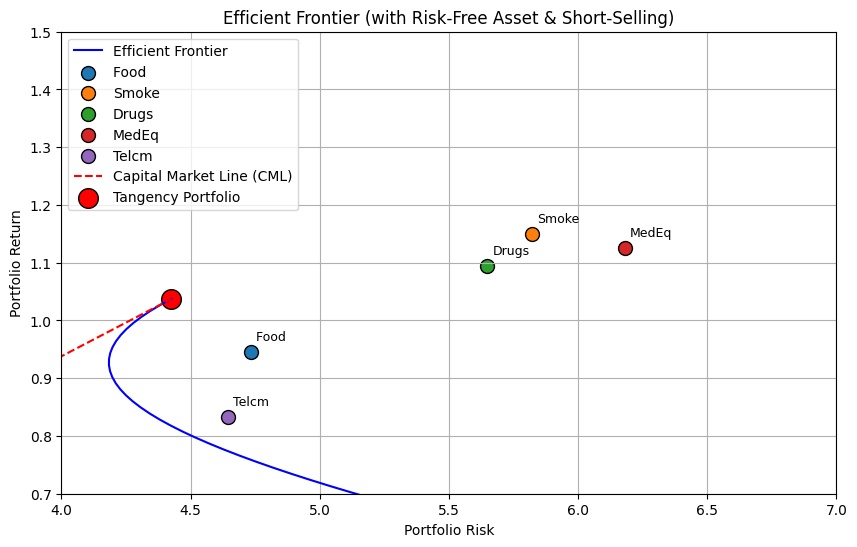

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

risk_free_rate = 0.004

# Step 1: Calculate mean returns and covariance matrix of the returns
mean_returns = selected_df.mean()
cov_matrix = selected_df.cov()

# Number of assets (industries)
n_assets = len(mean_returns)

# Step 2: Define the objective function to minimize the portfolio variance
def objective(weights, cov_matrix):
    return 0.5 * np.dot(weights.T, np.dot(cov_matrix, weights))

# Step 3: Define the constraint that the weights sum to 1
def constraint1(weights):
    return np.sum(weights) - 1

# Step 4: Compute the tangency portfolio (maximize the Sharpe ratio)
# Calculate excess returns (returns minus risk-free rate)
excess_returns = mean_returns - risk_free_rate

# Inverse of covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Tangency portfolio weights
tangency_weights = np.dot(inv_cov_matrix, excess_returns) / np.sum(np.dot(inv_cov_matrix, excess_returns))

# Calculate the tangency portfolio return and volatility
tangency_return = np.dot(tangency_weights, mean_returns)
tangency_volatility = np.sqrt(np.dot(tangency_weights.T, np.dot(cov_matrix, tangency_weights)))

# Step 5: Generate a range of target returns for the efficient frontier (with risk-free asset)
target_returns = np.linspace(risk_free_rate, tangency_return, 100)

# Calculate the efficient frontier with the risk-free asset and short-sale constraints
results = np.zeros((2, len(target_returns)))  # To store risk and return

for i, target_return in enumerate(target_returns):
    # Initial guess for portfolio weights (equal weights)
    initial_weights = np.ones(n_assets) / n_assets
    
    # Define the constraints for this target return
    constraints = [
        {'type': 'eq', 'fun': constraint1},  # Weights sum to 1
        {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target_return}  # Portfolio return equals target
    ]
    
    # Define the bounds for the weights (weights can be negative, no other bounds)
    bounds = [(None, None) for _ in range(n_assets)]  # No upper or lower bounds for weights
    
    # Solve the optimization problem
    result = minimize(objective, initial_weights, args=(cov_matrix,), constraints=constraints, bounds=bounds)
    
    # Store the results
    weights = result.x
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    results[0, i] = portfolio_risk  # Store the portfolio risk (volatility)
    results[1, i] = portfolio_return  # Store the portfolio return

# Step 6: Plot the Efficient Frontier with the risk-free asset and individual industry portfolios

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the Efficient Frontier (with risk-free asset)
ax.plot(results[0], results[1], label="Efficient Frontier", color='b')

# Step 7: Plot the individual industry portfolios as scatter points
for i in range(n_assets):
    # Portfolio risk (volatility) and return for individual industries
    industry_return = mean_returns.iloc[i]
    industry_vol = np.sqrt(cov_matrix.iloc[i, i])  # Standard deviation of the individual industry
    
    # Scatter plot for the individual industry portfolio
    ax.scatter(industry_vol, industry_return, label=selected_df.columns[i], s=100, edgecolors='black', marker='o')

    # Annotate each industry portfolio with its name
    ax.text(industry_vol + 0.02, industry_return + 0.02, selected_df.columns[i], fontsize=9)

# Step 8: Plot the Capital Market Line (CML)
# The CML starts at the risk-free rate (0, risk_free_rate) and ends at the tangency portfolio
cml_x = np.linspace(0, tangency_volatility, 100)
cml_y = risk_free_rate + (cml_x / tangency_volatility) * (tangency_return - risk_free_rate)
ax.plot(cml_x, cml_y, label="Capital Market Line (CML)", color='r', linestyle='--')

# Step 9: Plot the Tangency Portfolio
ax.scatter(tangency_volatility, tangency_return, color='red', s=200, label="Tangency Portfolio", edgecolors='black')

# Set the axis limits
ax.set_ylim(0.7, 1.5)  # y-axis range for return
ax.set_xlim(4.0, 7.0)  # x-axis range for risk (volatility)

# Customize the plot with titles and labels
ax.set_title('Efficient Frontier (with Risk-Free Asset & Short-Selling)')
ax.set_xlabel('Portfolio Risk')
ax.set_ylabel('Portfolio Return')

# Show the plot
ax.grid(True)
ax.legend(loc='upper left')
plt.show()
